In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!ls
import os 

box_in_scene.png  chees.jpg	objectDetectionOpenCV.ipynb
box.png		  matching.png	simple.jpg


In [3]:
os.chdir('drive/My Drive/Umakit')

What is the feature?

https://docs.opencv.org/master/df/d54/tutorial_py_features_meaning.html

**Main Component Of Feature Detection And Matching**


**Detection**: Identify the Interest Point

**Description**: The local appearance around each feature point is described in some way that is (ideally) invariant under changes in illumination, translation, scale, and in-plane rotation. We typically end up with a descriptor vector for each feature point.

**Matching**: Descriptors are compared across the images, to identify similar features. For two images we may get a set of pairs (Xi, Yi) ↔ (Xi`, Yi`), where (Xi, Yi) is a feature in one image and (Xi`, Yi`) its matching feature in the other image.

Feature Detecion Algorithms



*   [SIFT](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html) (Scale-Invariant Feature Transform)
*   [SURF](https://docs.opencv.org/master/df/dd2/tutorial_py_surf_intro.html) (Speeded-Up Robust Features)
*   [FAST](https://docs.opencv.org/master/df/d0c/tutorial_py_fast.html) Algorithm for Corner Detection
*   [BRIEF](https://docs.opencv.org/master/dc/d7d/tutorial_py_brief.html) (Binary Robust Independent Elementary Features)
*   [ORB](https://docs.opencv.org/master/d1/d89/tutorial_py_orb.html) (Oriented FAST and Rotated BRIEF)








**ORB (Oriented FAST and Rotated BRIEF)**







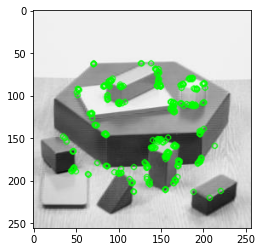

In [21]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('img/simple.jpg',0)
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show();

`**OpenCV Feature Matching Algorithms**

Features matching or generally image matching, a part of many computer vision applications such as image registration, camera calibration and object recognition, is the task of establishing correspondences between two images of the same scene/object. A common approach to image matching consists of detecting a set of interest points each associated with image descriptors from image data. Once the features and their descriptors have been extracted from two or more images, the next step is to establish some preliminary feature matches between these images.

We know a great deal about feature detectors and descriptors. It is time to learn how to match different descriptors. OpenCV provides two techniques, Brute-Force matcher and FLANN based matcher.

1.   Brute-Force Matcher
2.   FLANN(Fast Library for Approximate Nearest Neighbors) Matcher









**Algorithm For Feature Detection And Matching**




*   Find a set of distinctive keypoints
*   Define a region around each keypoint
*   Extract and normalize the region content
*   Compute a local descriptor from the normalized region
*   Match local descriptors

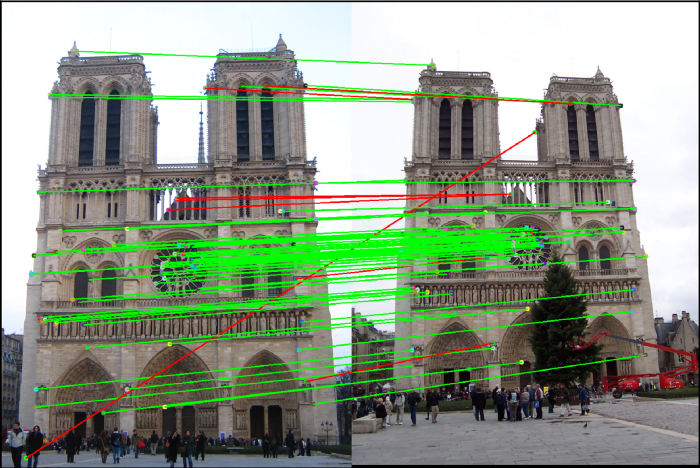

In [22]:
from IPython.display import Image
Image('img/matching.png')

**Brute-Force Matching with ORB Descriptors**

Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

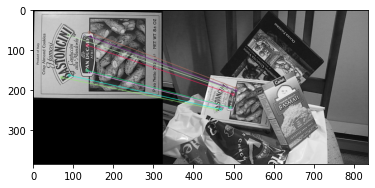

In [6]:
#We are using ORB descriptors to match features. So let's start with loading images, finding descriptors etc.

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('img/box.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('img/box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)


"""Next we create a BFMatcher object with distance measurement cv.NORM_HAMMING (since we are using ORB) and crossCheck is switched on for better results.
 Then we use Matcher.match() method to get the best matches in two images. We sort them in ascending order of their distances so that best matches (with low distance) come to front.
Then we draw only first 10 matches (Just for sake of visibility. You can increase it as you like)"""

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# cv.drawMatchesKnn ile k icin farkli degerler secilerek en iyi sonuclar gorulebilir.
# img3=cv.resize(img3,(384,836))
plt.imshow(img3),plt.show();


**Brute-Force Matching with SIFT Descriptors and Ratio Test**

This time, we will use BFMatcher.knnMatch() to get k best matches. In this example, we will take k=2 so that we can apply ratio test explained by D.Lowe in his paper.

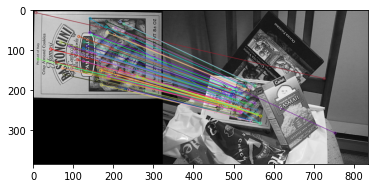

In [18]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('img/box.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('img/box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()# find the keypoints and descriptors with SIFT
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show();

**FLANN based Matcher**

FLANN stands for Fast Library for Approximate Nearest Neighbors. It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. It works faster than BFMatcher for large datasets. We will see the second example with FLANN based matcher.

In [11]:
'''For FLANN based matcher, we need to pass two dictionaries which specifies the algorithm to be used, its related parameters etc. First one is IndexParams. 
For various algorithms, the information to be passed is explained in FLANN docs. As a summary, for algorithms like SIFT, SURF etc. you can pass following:'''


FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

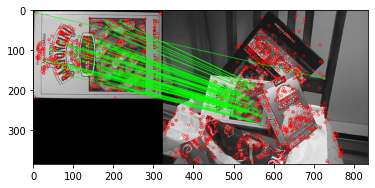

In [15]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('img/box.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('img/box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show();